<a href="https://colab.research.google.com/github/suryagokul/Data-Science-Portfolio/blob/master/Memory_based_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Memory-based collaborative filtering


>> **Recommend items based only on past user's behaviour.**


>>### **When do you use collaborative filtering?**
>>>- you don't have to have any domain expertise in terms of what you're recommending (e.g. books, movies, music, car)
>>>- leverage relationship between users

>>### **Types of collaborative filtering**
>>>- [***User-based***](#scrollTo=4DQ6Il8V7VzQ)
>>>- [***Item-based***](#scrollTo=pfxrib6Y7rlj)





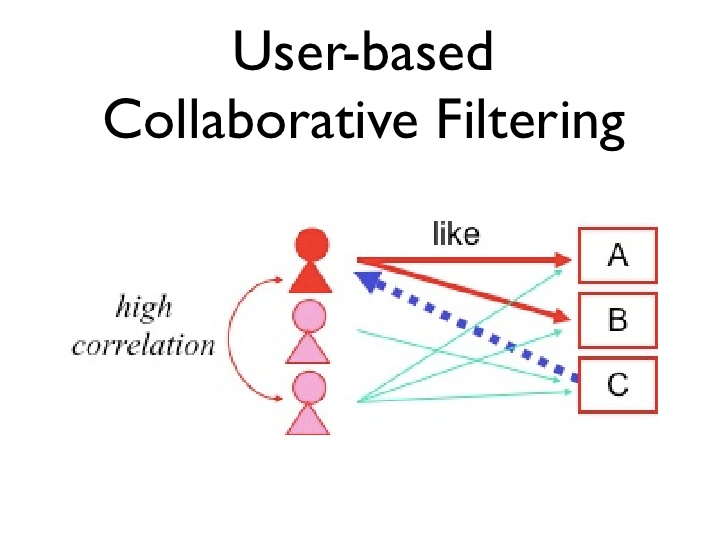

> **Item Based Collaborative Filtering**


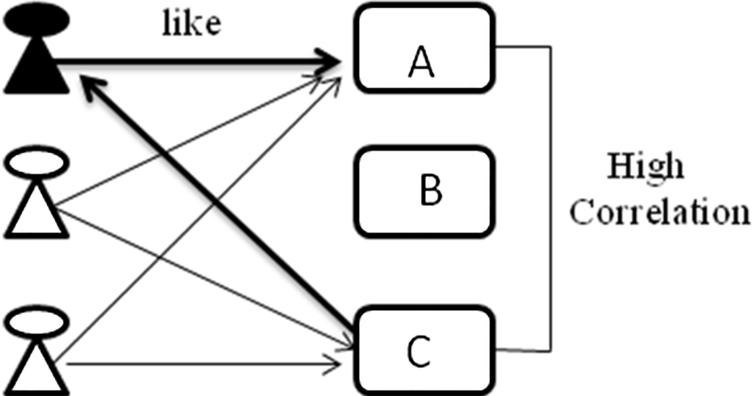

**Steps in building our collaborative filtering model:**
1. Identify the metrics you want to use for the target user
2. For each product, compute a prediction of rating that the target user would give to the product
    - Identify the set of users most similar to the target user according to a similarity function (e.g. neighbourhood function)
    - Identify the products these similar users liked
    - For each of the products identified at the previous step, compute a prediction of rating that the target user would give to the product
3. Return top K products

In [90]:
!pip install surprise          # Simple python library for Recommender Systems

[Surprise Library Documentation](https://yiyibooks.cn/sorakunnn/surprisesurprise-v1.0.5/surprise-v1.0.5/index.html)

[Collaborative filtering Using Surprise](https://realpython.com/build-recommendation-engine-collaborative-filtering/)

With the Surprise library, we will benchmark the following algorithms:


1.**Basic algorithms**
> ***NormalPredictor***

> > NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.


> ***BaselineOnly***


> > BaselineOnly algorithm predicts the baseline estimate for given user and item.


2.**k-NN algorithms** (Memory Based)


> ***KNNBasic***


> > KNNBasic is a basic collaborative filtering algorithm.


> ***KNNWithMeans***


> > KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.


> ***KNNWithZScore***


> > KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.


> ***KNNBaseline***


> > KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.


3.**Matrix Factorization-based algorithms** (Model Based)


> ***SVD***


> > SVD algorithm is equivalent to Probabilistic Matrix Factorization


> ***SVDpp***


> > The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.


> ***NMF***


> > NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.


> ***Slope One***


> > SlopeOne is a straightforward implementation of the SlopeOne algorithm.


> ***Co-clustering***


> > Coclustering is a collaborative filtering algorithm based on co-clustering.

#### Import Libraries 

In [91]:
from surprise import KNNWithMeans

from surprise import accuracy

from surprise import Dataset

from surprise.model_selection import train_test_split,cross_validate

from surprise import Reader,SVD,SVDpp,KNNBaseline,KNNWithMeans,KNNWithZScore

from surprise import KNNBasic,NormalPredictor,BaselineOnly,NMF,SlopeOne,CoClustering

import requests

import zipfile

from io import BytesIO

In [92]:
from surprise.model_selection import split

###  Get the data


We're going to use the MovieLens 100K dataset:
https://grouplens.org/datasets/movielens/100k/


We're going to download data ourselves, given that with your projects, probably data will not be available within `surprise`.

We are going to use the data in the `u.data` file that contains all the user-item ratings. 

In the u.data file each line represents a rating from a user to an item and the time when the rating happened. 

The format of each line is:
`userID itemID rating timestamp`, separated by tabs

In order to read the data, we're creating a Reader and define its format. In this case each line is divided as user item rating timestamp and is seperated by a tab \t. After we define the format we load our data in a Dataset object:

In [93]:
 data = Dataset.load_builtin('ml-100k')

##  Compute prediction of rating using Statistical Techniques


In oder to compute the similarity between users, most used methods are:
* **`Pearson Correlation`**  
* **`cosine similarity`**


We have the following as input data:
* A collection of users, $u_i$, $i=1, ...n$
* A collection of products $p_j$, $j=1, ...m$
* An $n$ x $m$ matrix of ratings $v_{ij}$, with $v_{ij}=?$ if user $i$ did not rate product $j$


### 2.1. Similarity measures

**Inner product:**

Basic similarity function:
$$inner(u_i, u_j) = \sum_{k=1}^{m} v_{ik} v_{jk}$$

**Cosine similarity:**

The inner product, however, is unbounded. 

One way to make it bounded between -1 and 1 is to divide by the vectors’ L2 norms, giving the cosine similarity:
$$cos(u_i, u_j) = \frac{\sum_{k=1}^{m} v_{ik} v_{jk}}{\sqrt{\sum_{k=1}^{m} v_{ik}^2\sum_{k=1}^{m} v_{jk}^2}}$$


**Pearson correlation:**

Cosine similarity is not invariant to shifts. What is invariant, though, is the Pearson correlation because it takes into account the mean of the vectors. Let $v_i$ and $v_k$ be the means of the two vectors:
 
$$u_{ik} = \frac{\sum_{j} (v_{ij} - v_{i})(v_{kj} - v_{k})}{\sqrt{\sum_{j} (v_{ij} - v_i)^2\sum_{j} (v_{kj} - v_k)^2}}$$


**Computing similarities**

|  | HP1 | HP2 | HP3 | TW | SW1 | SW2 | SW3 |
|---|---|---|---|---|---|---|---|
| A |4| | | 5 | 1 | | |
| B |5|5|4| | | | |
| C | | | |2|4|5| |
| D | |3 | | | | |3 |
| E | 5|2 | | |  | |  1|
| F |  |4 | | | 4 | |  3|


We can intuitively see that A and B have similar preferences, while A and C have different ones.
However, computing similarity by handling not rated movies with 0 does not reflect this difference that good.  Hence, we're going for pearson correlation, and the first step is computing the mean rating for each user: 

|  | HP1 | HP2 | HP3 | TW | SW1 | SW2 | SW3 | Mean |
|---|---|---|---|---|---|---|---|---|
| A |4| | | 5 | 1 | | |10/3|
| B |5|5|4| | | | |14/3|
| C | | | |2|4|5| |11/3|
| D | |3 | | | | |3 |3|
| E | 5|2 | | |  | |  1|8/3|
| F |  |4 | | | 4 | |  3|11/3|

Some people tend to be tough raters, while others tend to be easy raters. By substracting the mean of each row, we normalize the ratings, centering data around 0. This is why this is also called the centered cosine similarity.

|  | HP1 | HP2 | HP3 | TW | SW1 | SW2 | SW3 | Mean |
|---|---|---|---|---|---|---|---|---|
| A |2/3| | | 5/3 | -7/3 | | |10/3|
| B |1/3|1/3|-2/3| | | | |14/3|
| C | | | |-5/3|1/3|4/3| |11/3|
| D | |0 | | | | |0 |3|
| E | 7/3|-2/3 | | |  | |  -5/3|8/3|
| F |  |1/3 | | | 1/3 | |  -2/3|11/3|



## 1.1 User Based Collaborative Filtering

In [94]:
trainset,testset = train_test_split(data,test_size=0.2)

**KNNWithMeans**

In [95]:
user_based_algo = KNNWithMeans(k=50,sim_options={'name':'pearson_baseline','user_based':True})

In [96]:
user_based_algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


We can now predict ratings by directly calling the predict() method.

 Let’s say you’re interested in user 196 and item 300 (make sure they’re in the trainset!),

In [97]:
uid = str(196)

iid = str(300)

pred = user_based_algo.predict(uid,iid,verbose=True)

user: 196        item: 300        r_ui = None   est = 3.66   {'actual_k': 50, 'was_impossible': False}


In [98]:
test_pred = user_based_algo.test(testset)

test_pred

[Prediction(uid='505', iid='422', r_ui=3.0, est=2.5744660984717513, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid='48', iid='308', r_ui=5.0, est=2.8122860466489055, details={'actual_k': 13, 'was_impossible': False}),
 Prediction(uid='393', iid='576', r_ui=3.0, est=3.2610492822689787, details={'actual_k': 37, 'was_impossible': False}),
 Prediction(uid='619', iid='346', r_ui=3.0, est=3.4849212049532796, details={'actual_k': 49, 'was_impossible': False}),
 Prediction(uid='154', iid='289', r_ui=2.0, est=3.2046649317703406, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='720', iid='313', r_ui=3.0, est=4.727520075397856, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='533', iid='408', r_ui=4.0, est=4.359499715232226, details={'actual_k': 35, 'was_impossible': False}),
 Prediction(uid='622', iid='50', r_ui=5.0, est=4.433041808962999, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='125', iid='211', r_ui=3.0, e

Evaluate the model 


Our model will try to optimize predictions, in order to match as closely as possible the actual results.

As we're trying to predict the rating of a certain user-movie combination, we will compare that prediction to the actual rating. The difference between the actual and the predicted rating is measured using classical error measurements such as Root mean squared error (RMSE) and Mean absolute error (MAE):


$$RMSE = \sqrt{\sum_{t=1}^{T}  {(\hat{y_t}-y_t)}^2 \over n}$$

$$MAE = {\sum_{t=1}^{T}  (\hat{y_t}-y_t) \over n}$$

Here, $\hat{y_t}$ is the prediction of $y_t$.


In [99]:
accuracy.rmse(test_pred,verbose=True)

RMSE: 0.9322


0.9321887066174042

**KNNWithZScore**

In [100]:
zscore_algo = KNNWithZScore(k=50,sim_options={'name':'pearson_baseline','user_based':True})

In [101]:
zscore_algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [102]:
uid = str(196)

iid = str(300)

pred = zscore_algo.predict(uid,iid,verbose=True)

user: 196        item: 300        r_ui = None   est = 3.69   {'actual_k': 50, 'was_impossible': False}


In [103]:
zscore_pred = zscore_algo.test(testset)

zscore_pred

[Prediction(uid='505', iid='422', r_ui=3.0, est=2.59928239004203, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid='48', iid='308', r_ui=5.0, est=2.9437622411740705, details={'actual_k': 13, 'was_impossible': False}),
 Prediction(uid='393', iid='576', r_ui=3.0, est=3.256404781738622, details={'actual_k': 37, 'was_impossible': False}),
 Prediction(uid='619', iid='346', r_ui=3.0, est=3.488568508843146, details={'actual_k': 49, 'was_impossible': False}),
 Prediction(uid='154', iid='289', r_ui=2.0, est=3.3255012887224815, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='720', iid='313', r_ui=3.0, est=4.506667676040631, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='533', iid='408', r_ui=4.0, est=4.428963600453379, details={'actual_k': 35, 'was_impossible': False}),
 Prediction(uid='622', iid='50', r_ui=5.0, est=4.5238081614698435, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='125', iid='211', r_ui=3.0, est=

In [104]:
accuracy.rmse(zscore_pred,verbose=True)

RMSE: 0.9332


0.9332045572492063

In [105]:
# Download archive and extract its contents.
ml_100k_url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
r = requests.get(ml_100k_url, stream=True)
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall()

In [106]:
 file_name = './ml-100k/u.item'
rid_to_name = {}
name_to_rid = {}
with open(file_name, 'r', encoding='ISO-8859-1') as f:
    for line in f:
        line = line.split('|')
        rid_to_name[line[0]] = line[1]
        name_to_rid[line[1]] = line[0]
        

In [107]:
rid_to_name

{'1': 'Toy Story (1995)',
 '2': 'GoldenEye (1995)',
 '3': 'Four Rooms (1995)',
 '4': 'Get Shorty (1995)',
 '5': 'Copycat (1995)',
 '6': 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7': 'Twelve Monkeys (1995)',
 '8': 'Babe (1995)',
 '9': 'Dead Man Walking (1995)',
 '10': 'Richard III (1995)',
 '11': 'Seven (Se7en) (1995)',
 '12': 'Usual Suspects, The (1995)',
 '13': 'Mighty Aphrodite (1995)',
 '14': 'Postino, Il (1994)',
 '15': "Mr. Holland's Opus (1995)",
 '16': 'French Twist (Gazon maudit) (1995)',
 '17': 'From Dusk Till Dawn (1996)',
 '18': 'White Balloon, The (1995)',
 '19': "Antonia's Line (1995)",
 '20': 'Angels and Insects (1995)',
 '21': 'Muppet Treasure Island (1996)',
 '22': 'Braveheart (1995)',
 '23': 'Taxi Driver (1976)',
 '24': 'Rumble in the Bronx (1995)',
 '25': 'Birdcage, The (1996)',
 '26': 'Brothers McMullen, The (1995)',
 '27': 'Bad Boys (1995)',
 '28': 'Apollo 13 (1995)',
 '29': 'Batman Forever (1995)',
 '30': 'Belle de jour (1967)',
 '31': 'Crimson Tide

In [108]:
name_to_rid

{'Toy Story (1995)': '1',
 'GoldenEye (1995)': '2',
 'Four Rooms (1995)': '3',
 'Get Shorty (1995)': '4',
 'Copycat (1995)': '5',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': '6',
 'Twelve Monkeys (1995)': '7',
 'Babe (1995)': '8',
 'Dead Man Walking (1995)': '9',
 'Richard III (1995)': '10',
 'Seven (Se7en) (1995)': '11',
 'Usual Suspects, The (1995)': '12',
 'Mighty Aphrodite (1995)': '13',
 'Postino, Il (1994)': '14',
 "Mr. Holland's Opus (1995)": '15',
 'French Twist (Gazon maudit) (1995)': '16',
 'From Dusk Till Dawn (1996)': '17',
 'White Balloon, The (1995)': '18',
 "Antonia's Line (1995)": '19',
 'Angels and Insects (1995)': '20',
 'Muppet Treasure Island (1996)': '21',
 'Braveheart (1995)': '22',
 'Taxi Driver (1976)': '23',
 'Rumble in the Bronx (1995)': '24',
 'Birdcage, The (1996)': '25',
 'Brothers McMullen, The (1995)': '26',
 'Bad Boys (1995)': '27',
 'Apollo 13 (1995)': '28',
 'Batman Forever (1995)': '29',
 'Belle de jour (1967)': '30',
 'Crimson Tide (1995

In [109]:
movie_raw_id = name_to_rid['Batman Returns (1992)']

In [110]:
movie_raw_id

'231'

**What are raw and inner ids?**


Users and items have a raw id and an inner id. Some methods will use/return a raw id (e.g. the predict() method), while some other will use/return an inner id.

Raw ids are ids as defined in a rating file or in a pandas dataframe. They can be strings or numbers. Note though that if the ratings were read from a file which is the standard scenario, they are represented as strings. This is important to know **if you’re using e.g. predict() or other methods that accept raw ids as parameters.**

**On trainset creation, each raw id is mapped to a unique integer called inner id,** which is a lot more suitable for Surprise to manipulate. Conversions between raw and inner ids can be done using the to_inner_uid(), to_inner_iid(), to_raw_uid(), and to_raw_iid() methods of the trainset.

In [111]:
movie_inner_id1 = user_based_algo.trainset.to_inner_iid(movie_raw_id)

In [112]:
k=10

movie_neighbors1 = user_based_algo.get_neighbors(movie_inner_id1, k=10)

movie_neighbors1 = (user_based_algo.trainset.to_raw_iid(inner_id)
                       for inner_id in movie_neighbors1)

movie_neighbors1 = (rid_to_name[rid]
                       for rid in movie_neighbors1)

print('The {} nearest neighbors of Batman Returns (1992) using user based filtering are:'.format(k))
for movie in movie_neighbors1:
    print(movie)

The 10 nearest neighbors of Batman Returns (1992) using user based filtering are:
Usual Suspects, The (1995)
Birds, The (1963)
As Good As It Gets (1997)
It's a Wonderful Life (1946)
Jaws (1975)
Close Shave, A (1995)
Psycho (1960)
Muppet Treasure Island (1996)
Body Snatchers (1993)
Bob Roberts (1992)


## 1.2 Item Based Collaborative Filtering

In [113]:
item_based_algo = KNNWithMeans(k=50,sim_options={'name':'cosine','user_based':False})

In [114]:
item_based_algo.fit(trainset)
    

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [115]:
uid = str(196)

iid = str(300)

pred = item_based_algo.predict(uid,iid,verbose=True)

user: 196        item: 300        r_ui = None   est = 3.58   {'actual_k': 31, 'was_impossible': False}


In [116]:
predictions = item_based_algo.test(testset)

predictions

[Prediction(uid='505', iid='422', r_ui=3.0, est=2.2318419045666147, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='48', iid='308', r_ui=5.0, est=2.78349552017328, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='393', iid='576', r_ui=3.0, est=3.363090331590255, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='619', iid='346', r_ui=3.0, est=3.6774033265067043, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='154', iid='289', r_ui=2.0, est=2.999153295342695, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='720', iid='313', r_ui=3.0, est=4.73361499131854, details={'actual_k': 21, 'was_impossible': False}),
 Prediction(uid='533', iid='408', r_ui=4.0, est=4.4008337660722, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='622', iid='50', r_ui=5.0, est=4.337317476801856, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='125', iid='211', r_ui=3.0, est=3.68

In [117]:
accuracy.rmse(predictions,verbose=True)

RMSE: 0.9362


0.9361912358153173

In [118]:
movie_raw_id = name_to_rid['Batman Returns (1992)']

In [119]:
movie_inner_id = item_based_algo.trainset.to_inner_iid(movie_raw_id)

In [120]:
movie_inner_id

195

In [121]:
k=10

movie_neighbors = item_based_algo.get_neighbors(movie_inner_id, k=10)

movie_neighbors = (item_based_algo.trainset.to_raw_iid(inner_id)
                       for inner_id in movie_neighbors)

movie_neighbors = (rid_to_name[rid]
                       for rid in movie_neighbors)

print('The {} nearest neighbors of Batman Returns (1992) using item based filtering are:'.format(k))
for movie in movie_neighbors:
    print(movie)

The 10 nearest neighbors of Batman Returns (1992) using item based filtering are:
Once Upon a Time... When We Were Colored (1995)
Yankee Zulu (1994)
Thousand Acres, A (1997)
Unzipped (1995)
Bent (1997)
Night Falls on Manhattan (1997)
Pather Panchali (1955)
What Happened Was... (1994)
Colonel Chabert, Le (1994)
Metisse (Café au Lait) (1993)


In [122]:
item_based_algo.predict('190','327')     # (userid,movieid) predicting if user 190 see 327 movie then he will give 3.25 rating..

Prediction(uid='190', iid='327', r_ui=None, est=3.315265136127219, details={'actual_k': 50, 'was_impossible': False})